<a href="https://colab.research.google.com/github/kleineidam/LeafTransport/blob/main/ants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import numpy as np
from matplotlib import pyplot as plt

ImportError: cannot import name 'scipy' from 'matplotlib' (/usr/local/lib/python3.11/dist-packages/matplotlib/__init__.py)

# No memory

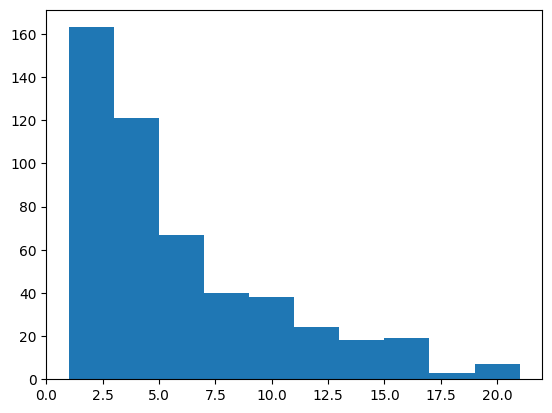

In [41]:
leaves = np.zeros(500)
leaf_moves = np.zeros_like(leaves)
for i in range(len(leaves)):
    for t in np.arange(100):
        #step forward
        leaves[i] += 1
        if np.random.randint(0,100) > 80:
            # DROP LEAF
            break

plt.hist(leaves);

# Memory

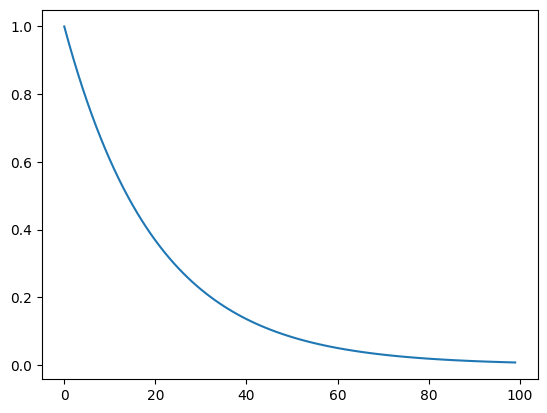

In [ ]:
t = np.arange(100)
plt.plot(t, np.exp(-t/20))

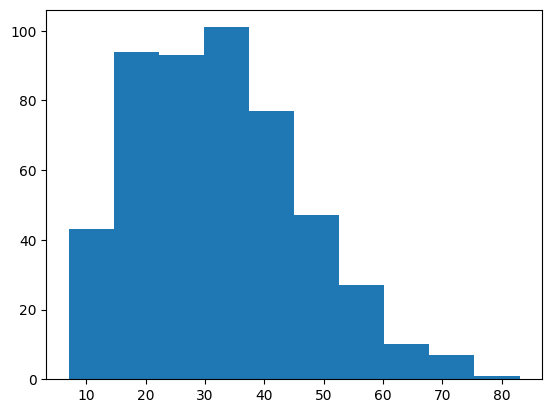

In [ ]:
leaves = np.zeros(500)
for i in range(len(leaves)):

    for t in np.arange(100):
        #step forward
        leaves[i] += 1
        motivation = 100 * np.exp(-t/500)
        if np.random.randint(0,100) > motivation:
            # DROP LEAF
            break

plt.hist(leaves);

# Reuptake and memory

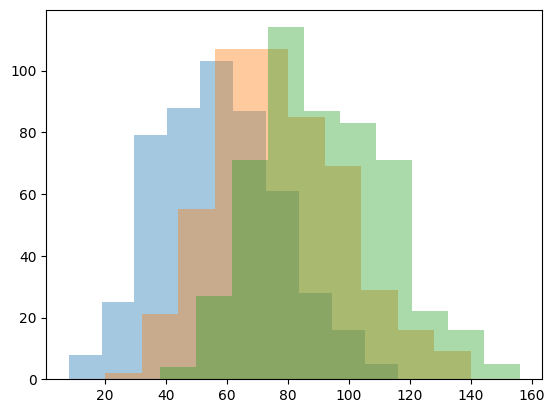

In [ ]:
leaves = np.zeros(500)

leaf_moves = np.zeros_like(leaves)
for t in np.arange(1000):
    for i in range(len(leaves)):
        if leaf_moves[i]:
            #step forward
            leaves[i] += 1
            # demotivator
            motivation = 100 * np.exp(-t/500)
            if  motivation < np.random.randint(0,100):
                # DROP LEAF
                leaf_moves[i] = False
        else:
            if np.random.randint(0,100) > 95:
                leaf_moves[i] = True

    if t%300==299:
        plt.hist(leaves, alpha=0.4);
        #print(t)

**Playground**

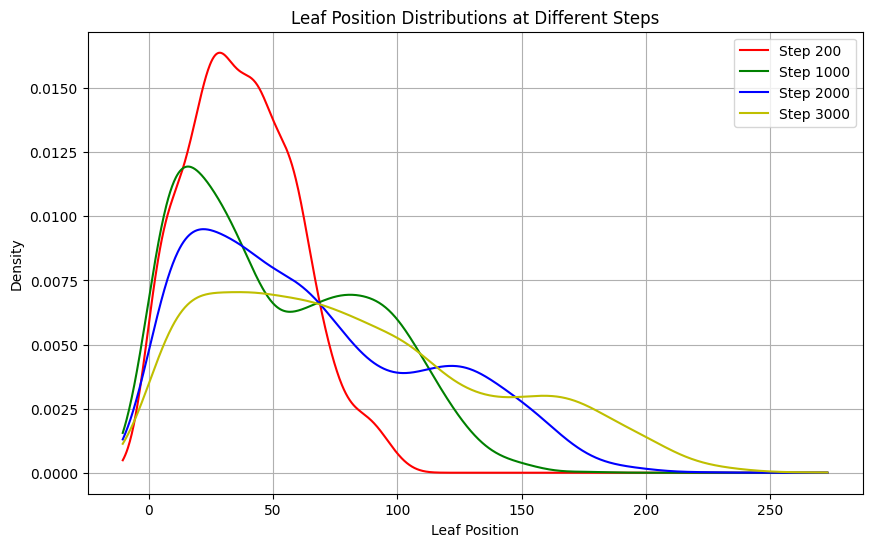

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Initial leaf setup
leaves = np.zeros(500)
leaf_moves = np.zeros_like(leaves, dtype=bool)

# Parameters for new leaf generation
generation_interval = 50
leaves_per_generation = 50
generation_mean = 0                # Keep around zero
generation_std = 0.5               # Small spread

# Checkpoints to store snapshots
checkpoints = [199, 999, 1999, 2999]
leaf_positions_at_checkpoints = []

for t in range(3000):
    motivation = 100 * np.exp(-t / 450)

    # Move active leaves
    moving = leaf_moves
    leaves[moving] += 1

    # Drop some moving leaves
    drop_mask = np.random.randint(0, 100, size=moving.sum()) > motivation
    leaf_moves[np.where(moving)[0][drop_mask]] = False

    # Randomly activate stationary leaves
    start_mask = (~leaf_moves) & (np.random.randint(0, 100, size=len(leaves)) > 95)
    leaf_moves[start_mask] = True

    # Generate new leaves near zero every interval
    if t % generation_interval == 0:
        new_positions = np.random.normal(loc=0, scale=generation_std, size=leaves_per_generation)
        leaves = np.concatenate([leaves, new_positions])
        leaf_moves = np.concatenate([leaf_moves, np.zeros(leaves_per_generation, dtype=bool)])

    if t in checkpoints:
        leaf_positions_at_checkpoints.append(leaves.copy())

# Plot the KDEs
plt.figure(figsize=(10, 6))

colors = ['r', 'g', 'b', 'y']
labels = [f"Step {cp + 1}" for cp in checkpoints]
x_vals = np.linspace(leaves.min() - 10, leaves.max() + 10, 1100)

for i, positions in enumerate(leaf_positions_at_checkpoints):
    kde = gaussian_kde(positions)
    plt.plot(x_vals, kde(x_vals), color=colors[i], label=labels[i])

plt.title("Leaf Position Distributions at Different Steps")
plt.xlabel("Leaf Position")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


generate leaves

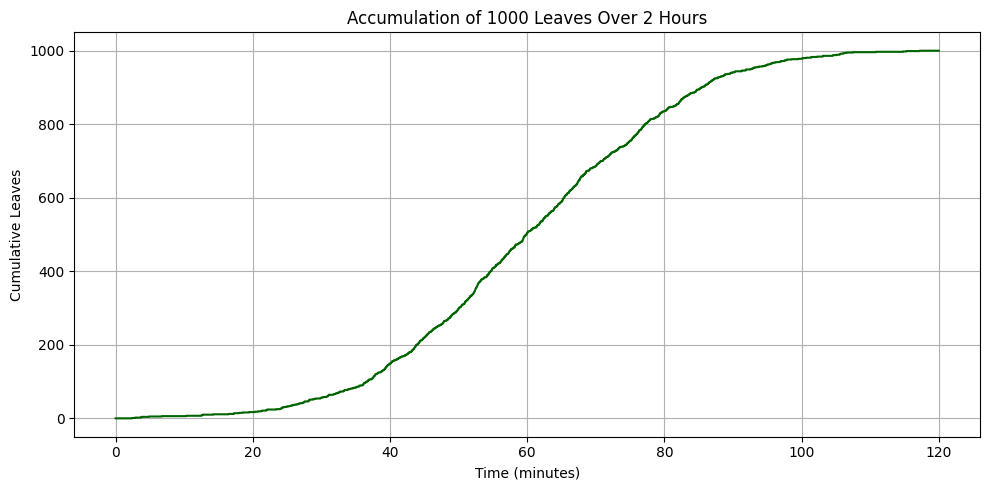

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# --- Simulation setup ---
duration_seconds = 2 * 60 * 60  # 2 hours = 7200 seconds
time = np.arange(duration_seconds)

# Gaussian shape for generation probability (peaks at 1 hour)
peak_time = duration_seconds / 2
std_dev = duration_seconds / 6  # wide spread (~2 std covers the 2-hour span)

# Probability density (not yet normalized)
pdf = np.exp(-0.5 * ((time - peak_time) / std_dev) ** 2)
pdf /= pdf.sum()  # normalize to sum to 1

# Total leaves to generate
total_leaves = 1000

# Generate number of leaves per second using multinomial distribution
leaf_counts_per_sec = np.random.multinomial(total_leaves, pdf)

# Accumulate
cumulative_leaves = np.cumsum(leaf_counts_per_sec)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(time / 60, cumulative_leaves, color='darkgreen')
plt.title("Accumulation of 1000 Leaves Over 2 Hours")
plt.xlabel("Time (minutes)")
plt.ylabel("Cumulative Leaves")
plt.grid(True)
plt.tight_layout()
plt.show()


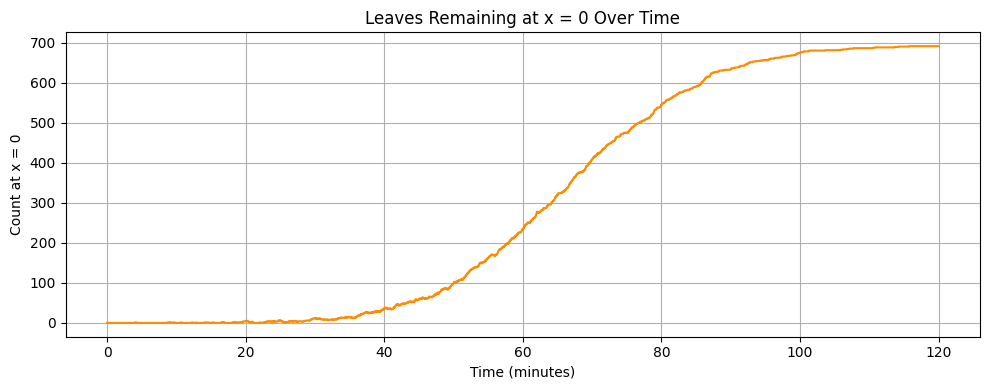

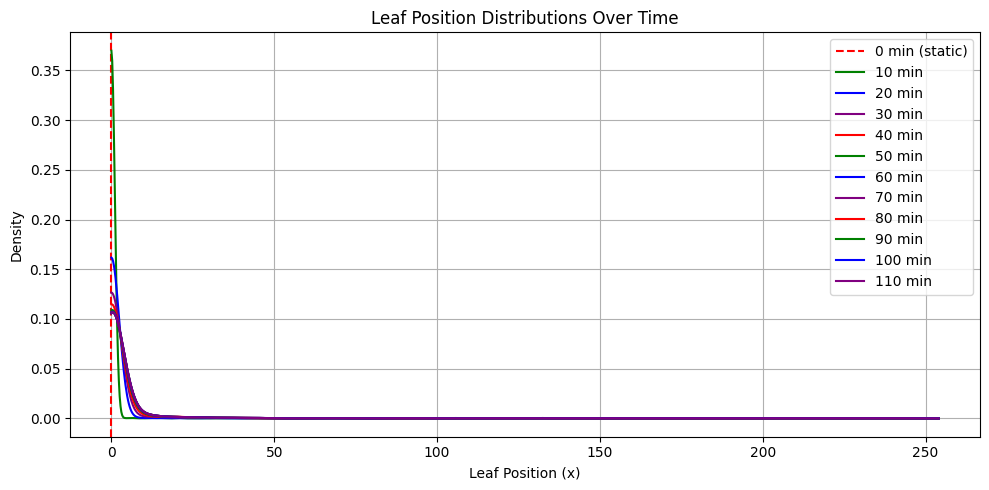

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- Parameters ---
duration_seconds = 2 * 60 * 60  # 2 hours
total_leaves = 1000
pickup_probability = 0.05

# Time array (seconds)
time = np.arange(duration_seconds)

# Leaf generation distribution (normal, peaking at 1 hour)
peak = duration_seconds / 2
std = duration_seconds / 6
pdf = np.exp(-0.5 * ((time - peak) / std) ** 2)
pdf /= pdf.sum()  # normalize

# Allocate leaves per second
leaves_per_sec = np.random.multinomial(total_leaves, pdf)

# Create start times for each leaf
start_times = []
for t, count in enumerate(leaves_per_sec):
    start_times.extend([t] * count)
start_times = np.array(start_times)
num_leaves = len(start_times)

# Initialize leaf states
positions = np.zeros(num_leaves, dtype=float)
moving = np.zeros(num_leaves, dtype=bool)

# Tracking
leaves_at_x0 = []
snapshots = []

# --- Simulation ---
for t in range(duration_seconds):
    motivation = 100 * np.exp(-t / 450)

    # Leaves created so far
    created_mask = start_times <= t

    # Try to pick up non-moving leaves
    not_moving_mask = created_mask & (~moving)
    pickup_trials = np.random.rand(not_moving_mask.sum())
    pickup_success = pickup_trials < pickup_probability
    pickup_indices = np.where(not_moving_mask)[0][pickup_success]
    moving[pickup_indices] = True

    # Move moving leaves probabilistically
    moving_mask = created_mask & moving
    move_trials = np.random.rand(moving_mask.sum())
    move_success = move_trials < (motivation / 100)
    move_indices = np.where(moving_mask)[0][move_success]
    positions[move_indices] += 1

    # Track how many leaves are still at x = 0
    leaves_at_x0.append(np.sum((positions == 0) & created_mask))

    # Save position snapshots every 10 minutes
    if t % 600 == 0:
        snapshots.append(positions.copy())

# --- Plot: Leaves at x = 0 over time ---
plt.figure(figsize=(10, 4))
plt.plot(time / 60, leaves_at_x0, label="At x = 0", color='darkorange')
plt.title("Leaves Remaining at x = 0 Over Time")
plt.xlabel("Time (minutes)")
plt.ylabel("Count at x = 0")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: KDEs of leaf positions ---
plt.figure(figsize=(10, 5))
colors = ['r', 'g', 'b', 'purple']
labels = [f"{(i * 10)} min" for i in range(len(snapshots))]

x_vals = np.linspace(0, max(positions) + 10, 1000)

for i, pos in enumerate(snapshots):
    # Check if data has enough variance for KDE
    if pos.std() > 1e-5:
        kde = gaussian_kde(pos)
        plt.plot(x_vals, kde(x_vals), color=colors[i % len(colors)], label=labels[i])
    else:
        # Plot as vertical line if all positions are the same
        plt.axvline(pos[0], color=colors[i % len(colors)], linestyle='--', label=f"{labels[i]} (static)")

plt.title("Leaf Position Distributions Over Time")
plt.xlabel("Leaf Position (x)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
